In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, pi, linspace
from scipy.io import wavfile
import IPython.display as ipd

# Stdlib imports
import os
import sys

# Lab 8

## Set your names on git!
To make it easier for me to grade, make sure you set your username to your **full name** as it appears on bcourses and set your email to be your Berkeley email account. Make sure to ssh onto the SCF cluster and do the same there.

Git configuration:
- Who are you? `git config --global user.name "Eli Ben-Michael"`
- How can I reach you? `git config --global user.email ebenmichael@berkeley.edu`

## Numpy and Matplotlib: A Basic Fourier Analysis Example


### Creating a Square Wave

We're going to look at reconstructing a square wave:

$$ y(t) = \text{sgn}(\sin(t))$$

First, create a function which returns a square wave

In [2]:
def square(npts=2000):
    """Create a real square wave.
    
    Parameters
    ----------
    npts : int, optional
      Number of points at which to sample the function.    

    Returns
    -------
    t : array
      The t values where the wave was sampled.
    y : array
      The square wave approximation (the final sum of all terms).
    """
    
    # get time points
    t = linspace(-pi, 2*pi, npts)
    
    # create the square wave
    y = np.sign(sin(t))

    return t, y

Now let's plot it.

In [3]:
def plot_square(npts=2000):
    """Plot a real sqaure wave

    Parameters
    ----------
    npts : int, optional
      Number of points at which to sample the function.
    """
    # create the square wave
    t, y = square(npts)
    # use the basic plt api
    plt.plot(t, y, label="True Wave")
    plt.grid()
    plt.legend()
    
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title('True Square Wave')

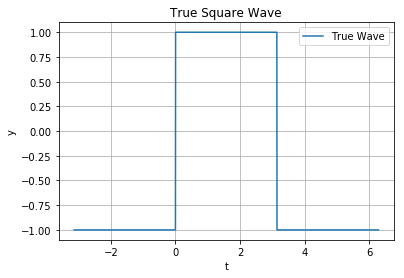

In [4]:
plot_square()

### Reconstructing a Square Wave with a Fourier Series
We can represent a square wave $y(t)$ as an infinite series:

$$ y(t) = \frac{4}{\pi}\sum_{i=0}^{\infty} \frac{1}{2i + 1} \sin((2i + 1) * t)$$

So, we can approximate a square wave with just a few terms of this sum.

In [5]:
def square_approx(nterms=5, npts=2000):
    """Add nterms to construct a square wave.

    Computes an approximation to a square wave using a total of nterms.
    
    Parameters
    ----------
    nterms : int, optional
      Number of terms to use in the sum.
    npts : int, optional
      Number of points at which to sample the function.

    Returns
    -------
    t : array
      The t values where the wave was sampled.
    y : array
      The square wave approximation (the final sum of all terms).
      """
    # create equally spaced time
    t = linspace(-pi, 2*pi, npts)
    # initialize the wave
    y = np.zeros_like(t)

    # add nterms terms in the infinite series
    for i in range(nterms):
        y += (1.0/(2*i+1))*sin((2*i+1)* t)
    y *= 4 / pi

    return t, y

Again, let's plot it

In [6]:
def plot_square_approx(terms, npts=2000):
    """Plot the square wave construction for a list of total number of terms.

    Parameters
    ----------
    terms : int or list of ints
      If a list is given, the plot will be constructed for all terms in it.
    npts : int, optional
      Number of points at which to sample the function.
    """
    
    if isinstance(terms, int):
        # Single term, just put it in a list since the code below expects a list
        terms = [terms]
        
    for nterms in terms:
        t, y = square_approx(nterms, npts)
        plt.plot(t, y, label='n=%s' % nterms)

    plt.grid()
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title('Square wave with n terms')

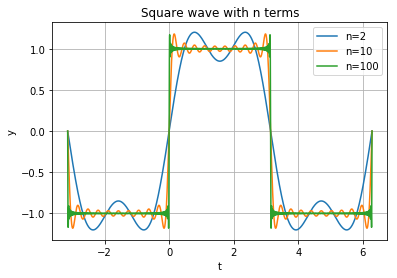

In [7]:
plot_square_approx([2, 10, 100])

And let's overlay the true square wave on top

In [8]:
def plot_both(terms, npts=2000):
    """Plot a true square wave and construction for a list of total number of terms.

    Parameters
    ----------
    terms : int or list of ints
      If a list is given, the plot will be constructed for all terms in it.
    npts : int, optional
      Number of points at which to sample the function.
    """
    
    # use our previous functions!
    
    plot_square(npts)
    plot_square_approx(terms, npts)
    plt.grid()

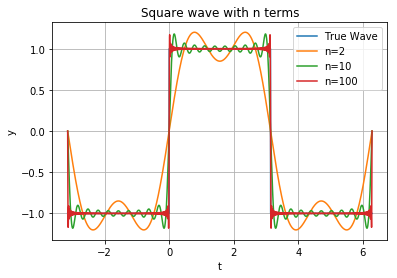

In [9]:
plot_both([2, 10, 100])

We can also plot the individual components of the sum to get some intuition

In [10]:
def square_terms(nterms=5, npts=500):
    """Compute all nterms to construct a square wave.

    Computes an approximation to a square wave using a total of nterms, and
    returns the individual terms as well as the final sum.
    
    Parameters
    ----------
    nterms : int, optional
      Number of terms to use in the sum.
    npts : int, optional
      Number of points at which to sample the function.

    Returns
    -------
    t : array
      The t values where the wave was sampled.
    y : array
      The square wave approximation (the final sum of all terms).
    terms : array of shape (nterms, npts)
      Array with each term of the sum as one row.
      """
    t = linspace(-pi, 2*pi, npts)
    terms = np.zeros((nterms, npts))
    for i in range(nterms):
        terms[i] = 4 / pi * (1.0/(2*i+1))*sin( (2*i+1)* t)
    y = terms.sum(axis=0)
    return t, y, terms

In [11]:
def plot_square_terms(nterms, npts=2000):
    """Plot individual terms of square wave construction.
    Parameters
    ----------
    nterms : int, optional
      Number of terms to use in the sum.
    npts : int, optional
      Number of points at which to sample the function.
    """
    # first plot the true wave
    plot_square(npts)
    
    # plot individual terms
    t, y, terms = square_terms(nterms)
    for i,term in enumerate(terms):
        plt.plot(t, term, label='freq=%i' % (2*i+1))
    
    # plot the reconstruction
    plt.plot(t, y, color='k', linewidth=2, label='sum')
    plt.legend()
    plt.grid()
    plt.title('Individual components of a square wave')

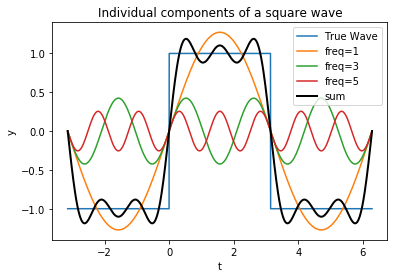

In [12]:
plot_square_terms(3)

### The Gibbs Phenomenon
Notice the weird jump we get even with a lot of terms. It's almost perfect except for at the discontinuity.

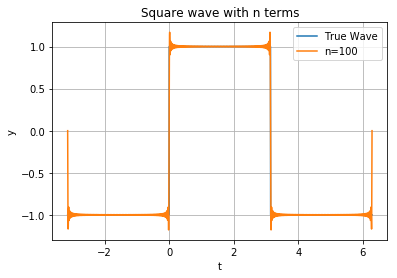

In [13]:
plot_both(100)

This is called the Gibbs Phenomenon, and shows a fundamental difficulty of approximating a discontinuous wave with a sum of continuous waves

### Audio compression with the Fast Fourier Transform
Just like we can represent the square wave as an infinite sum, we can represent a discretely sampled wave as a finite sum over frequencies. We can compute the coefficients of these frequencies with the *Discrete Fourier Transform* (DFT). If we bin up the frequencies into $k=1,2,\ldots$, the coeffient for frequency bin $k$ for wave $y$ is 
$$ c_k = \sum_{n=0}^{N-1} y_n e^\frac{-j2\pi kn}{N}$$
Essentially, the DFT computes the correlation of the signal with each frequency.

On a computer we can get samples from a wave. If the sampling rate is $r$ Hz, and the number of samples is $N$, the frequency corresponding to bin $k$ is 
$$f = \frac{kr}{N}$$

We can compute the coefficients explicitly by computing these sums directly. This is an $O(N^2)$ operation since we compute $N$ sums over $N$ variables. In practice engineers and researchers use the *Fast Fourier Transform* (FFT) to compute the DFT. The FFT uses symmetry of periodic functions to divide and conquer the sum and compute it with $O(N \log N)$ runtime.

Numpy has an FFT inplementation that we will use to reconstruct sound waves.

First, read in some data.

In [14]:
infile = 'data/CallRingingIn.wav'
rate, y = wavfile.read(infile)

What is this?

In [15]:
ipd.Audio(infile)

Exercise: create a function to plot the wave.

In [16]:
def plot_wave(y, rate):
    """P
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    rate : float
      Sampling rate of signal in Hz
    """
    
    ## Your code here

Similar to the square wave, we can approximate the signal by only keeping the frequencies with the highest magnitude. Let's compute the FFT and plot the magnitudes. We'll show a straightforward implementation of a `plot_dft` function to illustrate how the data is structured, but in practice we'll use the matplotlib [`plt.psd`](https://matplotlib.org/api/mlab_api.html#matplotlib.mlab.psd) function which uses a windowed approach to better extract the peaks in the data:

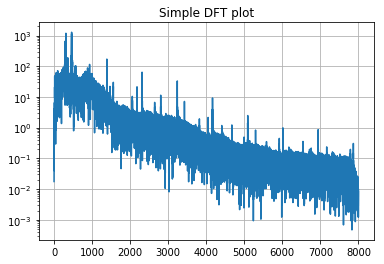

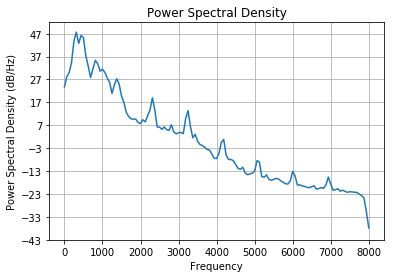

In [17]:
def plot_dft(y, rate, ax=None):
    """Plot a signal in the frequency domain
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    rate : float
      Sampling rate of signal in Hz    
    """
    
    n = len(y)
    
    # compute the real FFT
    out = np.fft.rfft(y) * 2 / n
    
    # Note that nf may be off by one from n, see rfft docs for details
  
    # get the frequencies
    freqs = np.linspace(0, rate/2, len(out))
    # Typically power information is plotted on a log scale, as it often decays (for real-
    # world signals) as a power law
    if ax is None:
        f, ax = plt.subplots()
        
    ax.semilogy(freqs, np.abs(out))
    ax.set_title('Simple DFT plot')
    ax.grid()
    return ax
    
    
plot_dft(y, rate)

# In practice, we use the psd function:
f, ax = plt.subplots()
ax.psd(y, Fs=rate)
ax.set_title('Power Spectral Density');

## Exercise

Given a function which computes the FFT, write a function which zeros out all coefficients except for the top frequencies and then inverts the DFT to get a reconstructed signal.

In [18]:
def fourier_approx(y, rate, frac=0.5):
    """ Approximate a signal with the top frac frequencies
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    rate : float
      Sampling rate of signal in Hz 
    frac : float, optional
      Fraction of frequencies to keep, defaults to 0.5
    
    Returns
    -------
    y_approx : array
      Approximated signal.
    """
    
    # compute (real) fourier transform
    n = len(y)
    out = np.fft.rfft(y)
    
    # compute the magnitudes of the coefficients and keep the top frac
    # zeroing out everything else
    
    ## Your code here
    ## Hint: after you get the magnitudes, you may want to look up how argsort works
    ## to find which frequency components you need to zero out
    
    y_approx = np.fft.irfft(out)
    
    return(y_approx)

Now let's plot the signal and the approximated signal side by side.

In [19]:
def plot_approx(y, y_approx, rate, frac=0.5):
    """Plot an audio signal and its approximation.
    Parameters
    ----------
    y : ndarray
      Audio signal as a numpy array
    y_approx: ndarray
      Approximated audo signal
    rate : float
      Sampling rate of signal in Hz 
    frac : float, optional
      Fraction of frequencies to keep, defaults to 0.5
    """
    shorter_y = y[:-1]
    # get the time points
    t = np.arange(len(shorter_y), dtype=float)/rate

    # Make a figure with two axes, one for time-domain and one for frequency-domain plots
    f, (at, af) = plt.subplots(2, 1, figsize=(14,10))

    # Plots in the time domain
    # Original and approximate signal
    at.plot(t, shorter_y, label='original', lw=1)
    at.plot(t, y_approx, label='approx', lw=1)
    at.set_xlabel('time (s)')
    at.set_ylabel('Signal amplitude')
    at.grid()
    at.legend()
    at.set_title(f'Approx signal {frac * 100:2g}% of the total frequencies')
    
    # Plots in the frequency domain
    af.psd(y, label='original')
    af.psd(y_approx, label='approx')
    af.legend()

In [20]:
frac = .01
y_approx = fourier_approx(y, rate, frac)

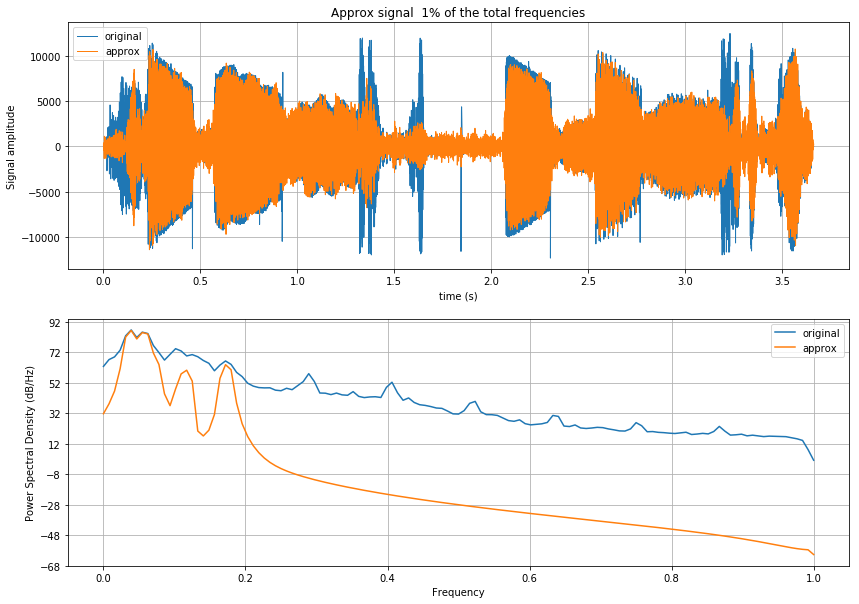

In [21]:
plot_approx(y, y_approx, rate, frac=frac)

In this case it can be illustrative to look at the raw (unwindowed) frequencies visualized with our basic `plot_dft` routine:

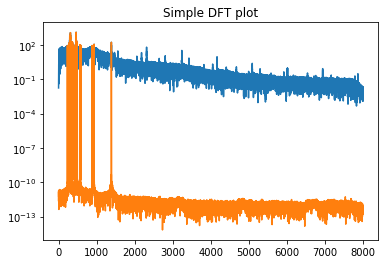

In [22]:
ax = plot_dft(y, rate)
plot_dft(y_approx, rate, ax=ax);

Now let's convert into a wav file and take a listen.

In [23]:
# linearly rescale raw data to wav range and convert to integers
sound = y_approx.astype(np.int16)
basename, ext = os.path.splitext(infile)
new_filename = f'{basename}_frac{100*frac:2g}.wav'
wavfile.write(new_filename, rate, sound)

Let's now compatre the two signals, the original and the compressed one:

In [24]:
print("Original:")
ipd.display(ipd.Audio(infile))
print("Compressed:")
ipd.display(ipd.Audio(new_filename))

Original:


Compressed:
